<div align="center">
<br/><font size="6">Corpus Batch Processing : Twitter Customer Service 2.8M tweets</font>    
<br/><font size="5">Optimize NLP preprocessing pipeline with batch a processing technique.</font>    
<br/><font size="4">Preprocess millions of sentences in a few hours instead of tens.</font>    
<br/>(c) Tristan Vanrullen 2022<br/>
</div>

- [Github source code and notebooks](https://github.com/TristanV/open_studies)
- [Medium.com](https://tristanv.medium.com/)
- [LinkedIn](https://www.linkedin.com/in/tristan-vanrullen/)
- [ResearchGate](https://www.researchgate.net/profile/Tristan-Vanrullen)



--- 

# Introduction

The purpose of this notebook is to **compare execution time** for several NLP preprocessing techniques, on a large *sentences-millionnaire* dataset .

- We first observe run time of a NLP pipeline, over several subsets of the dataset, to get some insights about the pipeline complexity.
- Then we propose a method to compute the optimal batch number to obtain the better batch-processing time.
- Finally we use this optimal batch number in an optimized batch-processing loop over the same NLP pipeline. 

Remark : In this notebook, because we run pipelines for the only purpose to run and benchmark pipelines, we do not really have to build a robust and efficient pipeline covering all NLP aspects! For this reason, we will focus on a few regex transformations, and POS Tagging + Lemmatizing algorithms.


## Initialisation

In [1]:
# Load some libraries we may need

import pandas as pd
import numpy as np
import math
from time import time

import string 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
 
from IPython.display import display, Image, HTML, clear_output  


from os.path import exists
from os import remove
from tqdm import tqdm

import re 
import nltk  
nltk.download('punkt')
from nltk import sent_tokenize 
from nltk.tag.util import untag  
import spacy
import en_core_web_sm

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tristan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## The dataset


Let's work with the [Tweets Customer Support corpus](https://www.kaggle.com/thoughtvector/customer-support-on-twitter).

The dataset is available with license [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). 
However, there is no clue that this license is provided with Twitter's agreement
- see no answer to this post https://www.kaggle.com/thoughtvector/customer-support-on-twitter/discussion/113693, 
- see this answer related to the Sentiment140 dataset disclosure : https://groups.google.com/g/sentiment140/c/lu9WuBulUhw?pli=1 
- and see Twitter T&Cs : https://developer.twitter.com/en/developer-terms/commercial-terms




In [2]:
dataset_path="./dataset/twcs/"
corpus_filename='twcs.csv'


In [114]:
t0=time()

documents = pd.read_csv(dataset_path+corpus_filename)

print('Reading the documents dataset',dataset_path+corpus_filename,' Loading time = ',time()-t0,'s')

Reading the documents dataset ./dataset/twcs/twcs.csv  Loading time =  11.446378469467163 s


In [115]:
display(documents)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [116]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


## Focus on text

In the present study, we are just interested in processing the documents texts with a NLP pipeline, so let's remove all other features.

In [117]:
documents = documents[['tweet_id','text']]

In [118]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   tweet_id  int64 
 1   text      object
dtypes: int64(1), object(1)
memory usage: 42.9+ MB


In [119]:
documents_initial_working_file = dataset_path+"documents_txt.pkl"
documents.to_pickle(documents_initial_working_file)

## Quick data study

In [9]:
documents['length']=documents["text"].str.len()

In [10]:
print(" --- "*5)
print("Shortest documents : ")
display(documents.sort_values(by="length").head())
print()
print(" --- "*5)
print("Longest documents:")
display(documents.sort_values(by="length").tail())

 ---  ---  ---  ---  --- 
Shortest documents : 


,tweet_id,text,length
1445676,1589946,I,1
1984240,2141004,I,1
1842610,1999609,?,1
2342740,2509343,I,1
2220503,2383993,🍺,1



 ---  ---  ---  ---  --- 
Longest documents:


,tweet_id,text,length
2806139,2982387,@822577 @822576 @822578 @822579 @822580 @82258...,490
2806152,2982400,@822576 @822573 @822580 @822583 @822584 @82257...,493
1969278,2125453,@625926 @comcastcares @116136 @115900 @359957 ...,495
191819,225702,@169917 @426 @427 @81 @169918 @169919 @160959 ...,507
217042,252568,@176042 @176031 @176045 @176044 @176047 @17604...,513


## Emojis?


In [11]:
emoji_dict = {
":)": "_emo_pos_",
":‑)": "_emo_pos_",
":-]": "_emo_pos_",
":-3": "_emo_pos_",
":->": "_emo_pos_",
"8-)": "_emo_pos_",
":-}": "_emo_pos_",
":o)": "_emo_pos_",
":c)": "_emo_pos_",
":^)": "_emo_pos_",
"=]": "_emo_pos_",
"=)": "_emo_pos_",
"<3": "_emo_pos_",
":-(": "_emo_neg_",
":(": "_emo_neg_",
":c": "_emo_neg_",
":<": "_emo_neg_",
":[": "_emo_neg_",
">:[": "_emo_neg_",
":{": "_emo_neg_",
">:(": "_emo_neg_",
":-c": "_emo_neg_",
":-< ": "_emo_neg_",
":-[": "_emo_neg_",
":-||": "_emo_neg_"
}
# display(emoji_dict)

In [12]:
def lookup_dict(text, dictionary):
    for key,value in dictionary.items():
        text = text.replace(key, value)
    return text

In [13]:
documents['emoji_text'] = documents['text'].apply(lambda x: lookup_dict(x,emoji_dict))


In [14]:
print("documents containing positive emoji:",len(documents[documents['emoji_text'].str.contains("_emo_pos_")]))
display(documents[documents['emoji_text'].str.contains("_emo_pos_")].head())
print("documents containing negative emoji:",len(documents[documents['emoji_text'].str.contains("_emo_neg_")]))
display(documents[documents['emoji_text'].str.contains("_emo_neg_")].head())

documents containing positive emoji: 32981


,tweet_id,text,length,emoji_text
109,192,@115748 We've let our team know we can do bett...,77,@115748 We've let our team know we can do bett...
125,209,@115753 It appears this has been removed. Than...,75,@115753 It appears this has been removed. Than...
244,335,"@115797 Hi Loreen,correction done! :) See you ...",70,"@115797 Hi Loreen,correction done! _emo_pos_ S..."
251,342,@115797 Hi Loreen :) Kindly DM us the booking ...,128,@115797 Hi Loreen _emo_pos_ Kindly DM us the b...
255,348,"Lost your booking number? No worries, just dro...",138,"Lost your booking number? No worries, just dro..."


documents containing negative emoji: 11713


,tweet_id,text,length,emoji_text
271,379,@115803 Somebody else has told me!! I'm gutted...,57,@115803 Somebody else has told me!! I'm gutted...
849,1418,@ChipotleTweets Just got ghosted by Chipotle :...,133,@ChipotleTweets Just got ghosted by Chipotle _...
1052,1640,"@116060 Hi there, sorry to hear this :( I'll b...",89,"@116060 Hi there, sorry to hear this _emo_neg_..."
1131,1721,@AmazonHelp Never got the beta and now I’m bei...,152,@AmazonHelp Never got the beta and now I’m bei...
1254,1852,@116123 So sorry to disappoint. :-( *TAC,40,@116123 So sorry to disappoint. _emo_neg_ *TAC


Remark : we do not do any work on emojis and emoticons here, but this could be a job for a real-life documents analysis

# The NLP pipeline

In this notebook, because we run pipelines for the only purpose to run and benchmark pipelines, we do not really have to build a robust and efficient pipeline covering all NLP aspects! For this reason, we will focus on a few regex transformations, and POS Tagging + Lemmatizing algorithms.

In [15]:
## -----------------------------------------------------------------------------------
## NLP PREPROCESSING FUNCTIONS
## Here is a somehow basic pipeline with regex and POS tagging + lemmatizing
## emojis and emoticons are not handled

verbose_level = 0 # set to 1 or greater to be more verbose

### Some Regex

def re_linebreaks(textes): 
    global verbose_level
    t0 = time()
    result = [re.sub('[\n\r]', ' ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp line breaks removal","done in %0.3fs." % (time() - t0))
    return result

def re_hyperlinks(textes): 
    global verbose_level
    t0 = time() 
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'  
    result = [re.sub(pattern, ' _LINK_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp Hyperlinks patching","done in %0.3fs." % (time() - t0))
    return result

def re_dates(textes): 
    global verbose_level
    t0 = time()
    pattern = '\d+[\.\/-]\d+[\.\/-]\d+' 
    result = [re.sub(pattern, ' _DATE_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp Dates patching","done in %0.3fs." % (time() - t0))
    return result


def re_money(textes): 
    global verbose_level
    t0 = time()
    pattern = '\$[ ]?\d+((,|\.)\d+)?|\d+((,|\.)\d+)?[ ]?\$' 
    result = [re.sub(pattern, ' _MONEY_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp money patching","done in %0.3fs." % (time() - t0))
    return result

def re_numbers(textes): 
    global verbose_level
    t0 = time() 
    result = [re.sub('\d+((,|\.)\d+)?', ' _NUMBER_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp numbers patching","done in %0.3fs." % (time() - t0))
    return result
 

def re_ordinals(textes): 
    global verbose_level
    t0 = time() 
    result = [re.sub('\d+((,|\.)\d+)?(st|nd|rd|th)', ' _ORDINAL_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp ordinals patching","done in %0.3fs." % (time() - t0))
    return result


def re_arobace_usernames(textes): 
    global verbose_level
    t0 = time() 
    pattern = '([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)' # @user123_name 
    result = [re.sub(pattern, ' _USER_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp arobace_usernames patching","done in %0.3fs." % (time() - t0))
    return result

def re_hashtags(textes): 
    global verbose_level
    t0 = time() 
    pattern = '#\w*' #  #whatever 
    result = [re.sub(pattern, ' _HASHTAG_ ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp hashtag patching","done in %0.3fs." % (time() - t0))
    return result



def re_special_chars_except_punctuation(textes): 
    global verbose_level
    t0 = time() 
    result = [re.sub('[^\w.,;:!\?\-\' \n]+', ' ', t) for t in textes]
    if (verbose_level>0):
        print("Regexp special chars except punctuation cleaning","done in %0.3fs." % (time() - t0))
    return result


def re_special_chars(textes): 
    global verbose_level
    t0 = time() 
    
    result = [re.sub("[^\u0000-\u05C0\u2100-\u214F]+","",t) for t in textes] #non occidental characters 
    if (verbose_level>0):
        print("Regexp special chars cleaning","done in %0.3fs." % (time() - t0))
    return result

def re_remove_htmlentities(textes):
    global verbose_level
    t0 = time() 
    
    result = [re.sub('\&\w*;',"",t) for t in textes] # &whatever;
    if (verbose_level>0):
        print("Regexp HTML entities removal","done in %0.3fs." % (time() - t0))
    return result
    


def re_repeating_punctuation(textes): 
    global verbose_level
    t0 = time()  
    result = [re.sub(r'([.,;:!\?\-\'])\1*',r'\1', t) for t in textes]
    if (verbose_level>0):
        print("Regexp repeating punctuation chars cleaning","done in %0.3fs." % (time() - t0))
    return result



def re_whitespaces(textes): 
    global verbose_level
    t0 = time()  
    white_spaces = [re.sub(r'[ \t]{2,}', ' ', t) for t in textes]
#     white_spaces = [re.sub('[ \t]+', ' ', t) for t in textes]
    result = [re.sub('[ \t]+$', '', r) for r in white_spaces]       
    if (verbose_level>0):
        print("Regexp white spaces cleaning","done in %0.3fs." % (time() - t0))
    return result   


def apply_regex_transformers(funclist, textes,max_examples=0):
    global verbose_level
    
    if verbose_level>0:
        max_examples=1
        
    input_text = list(textes)
    for fname , f in funclist.items():
        if (max_examples>0):
            print("")
            print("------- "*6)
            print("------- "+fname+" example " + " ------- "*3)
        
        output_text=f(input_text)
        
        if (max_examples>0):
            count_samples=0
            print("------- "*6)
            for i in range(len(input_text)):
                if (output_text[i]!=input_text[i]):
                    count_samples = count_samples+1
                    print("--- Before : \n"+input_text[i])
                    print("--- After : \n"+output_text[i])
                    print()
                if count_samples==max_examples: 
                    break 
        input_text= output_text 
    return output_text

def get_regex_transformers():
    regex_transformers = {
        'newlines': re_linebreaks,
        'hyperlinks': re_hyperlinks,
        'dates': re_dates,
        'arobace usernames': re_arobace_usernames,
        'money': re_money,
        'ordinals': re_ordinals, 
        'numbers': re_numbers,  
        'hashtags':re_hashtags,
        'HTML entities removal':re_remove_htmlentities,
        'repeating punctuation chars':re_repeating_punctuation,
        'special_chars_except_punctuation': re_special_chars_except_punctuation,
        'special_chars': re_special_chars,
        'whitespaces': re_whitespaces
    } 
    return regex_transformers
 
def sentences_tokenizer(text_list):
    global verbose_level
    t0 = time() 
     
    # NLTK >=3.6.7 is required.
    # see https://github.com/nltk/nltk/issues/2927 
    # this call leads to a bug when the tweet starts with a '.'
    # issue from NLTK 3.6.6 (See #2925, #2921), and has been patched in NLTK 3.6.7
    sentences_list = [nltk.sent_tokenize(clean_text) if len(clean_text)>0 else [] for clean_text in text_list]
    
    if (verbose_level>0):
        print("Sentences tokenizer","done in %0.3fs." % (time() - t0))
    return sentences_list
 

# version qui tokenize,POS-tag en 1 passage avec spacy
def sentences_word_token_POS(sent_list):
    global verbose_level
    t0 = time() 
    # approche spacy
    # input = liste de documents, eux mêmes des listes de phrases
    # output = liste de documents, découpés en liste de phrases, découpées en listes de paires (lemma,POS-tag)
    nlp = spacy.load("en_core_web_sm",exclude=['lemmatizer','parser','ner'])
    
    special_tags=["_LINK_","_DATE_","_NUMBER_","_MONEY_","_ORDINAL_","_USER_","_HASHTAG_"]
    for special_tag in special_tags:
        nlp.tokenizer.add_special_case(special_tag, [{"ORTH": special_tag}])
    # on remplace les tags par une forme orthographique (par ex _LINK_ devient LINK ) après POS tagging, pour permettre un traitement deep learning plus pertinent dès le plongement
    sentences_token_POS_list=[[[(st.text.replace('_','') , st.pos_) for st in nlp(s)] for s in sent ] for sent in sent_list] 
    
    if (verbose_level>0):
        print("Sentences spacy tokenizing+POS chain","done in %0.3fs." % (time() - t0))
    return sentences_token_POS_list



# version qui tokenize,POS-tag, lemmatize en 1 passage avec spacy
def sentences_word_token_POS_lemma(sent_list):
    global verbose_level
    t0 = time() 
    # approche spacy
    # input = liste de documents, eux mêmes des listes de phrases
    # output = liste de documents, découpés en liste de phrases, découpées en listes de paires (lemma,POS-tag)
    nlp = spacy.load("en_core_web_sm",exclude=['parser','ner'])
    
    special_tags=["_LINK_","_DATE_","_NUMBER_","_MONEY_","_ORDINAL_","_USER_","_HASHTAG_"]
    for special_tag in special_tags:
        nlp.tokenizer.add_special_case(special_tag, [{"ORTH": special_tag}]) 
    # on remplace les tags par une forme orthographique (par ex _LINK_ devient LINK ) après POS tagging, pour permettre un traitement deep learning plus pertinent dès le plongement
    sentences_lemma_POS_list=[[[(st.lemma_ , st.pos_) if st.text[0]!="_" else (st.text.replace('_','') , st.pos_) for st in nlp(s)] for s in sent ] for sent in sent_list] 
    
    if (verbose_level>0):
        print("Sentences spacy tokenizing+POS+lemmatizing chain","done in %0.3fs." % (time() - t0))
    return sentences_lemma_POS_list

 

def sentence_lowercase(sent_POS_list):
    global verbose_level
    t0 = time() 
    sentences_filtered_list = []
    for sent_POS in sent_POS_list:
        sentences_filtered = []
        for s in sent_POS: 
    #         print("parsing",s)
            s = [(t.lower(),pos) for t,pos in s]
            sentences_filtered = sentences_filtered + [s]
        sentences_filtered_list = sentences_filtered_list + [sentences_filtered]
    if (verbose_level>0):
        print("Sentences lowercase filtering","done in %0.3fs." % (time() - t0))
    return sentences_filtered_list

def sentence_depunctuate(sent_POS_list):
    global verbose_level
    punctuations = set([',','.',';',':','!','?','-','...'])
    t0 = time() 
    sentences_filtered_list = []
    for sent_POS in sent_POS_list:
        sentences_filtered = []
        for s in sent_POS: 
    #         print("parsing",s)
            s = [(t,pos) for t,pos in s if t not in punctuations]
            sentences_filtered = sentences_filtered + [s]
        sentences_filtered_list = sentences_filtered_list + [sentences_filtered]
    if (verbose_level>0):
        print("Sentences depunctuation","done in %0.3fs." % (time() - t0))
    return sentences_filtered_list

 

def sentence_clean_empty(sent_POS_list):
    global verbose_level
    t0 = time() 
    sentences_filtered_list = []
    for sent_POS in sent_POS_list:
        sentences_filtered = [s for s in sent_POS if len(s)>0]
        sentences_filtered_list = sentences_filtered_list + [sentences_filtered]
    if (verbose_level>0):
        print("Sentences clean empty","done in %0.3fs." % (time() - t0))
    return sentences_filtered_list


def apply_sentence_transformers(funclist, sentences, max_examples=0):
    global verbose_level
    if verbose_level>0:
        max_examples=1
    input_sentences = list(sentences)
    for fname , f in funclist.items():
        if (f.__name__ in ["sentences_show_POS_stats","sentences_show_frequency_stats"]):
#         if (f == sentences_show_POS_stats): # ne fonctionne pas depuis l'intérieur de la fonction
            f(input_sentences,fname)
        else:
            if (max_examples>0):
                print("")
                print("------- "*6)
                print("------- "+fname+" example " + " ------- "*3)

            output_sentences=f(input_sentences)

            if (max_examples>0):
                count_samples=0
                print("------- "*6)
                for i in range(len(input_sentences)):
                    if (output_sentences[i]!=input_sentences[i]):
                        count_samples = count_samples+1
                        print("--- Before :")
                        print(input_sentences[i])
                        print("--- After :")
                        print(output_sentences[i])
                        print()
                    if count_samples==max_examples: 
                        break
                # fin boucle d'affichage des exemples
            # fin si affichage exemples
            input_sentences= output_sentences
    # fin boucle 
    return output_sentences


# token_transforming_method permet de choisir entre
# - le token original : "token"
# - le token lemmatisé : "lemma" 
def get_sentence_transformers(token_transforming_method="lemma"): 
    if token_transforming_method=="token":
        sentence_transformers = {
            'sentences tokenizer':sentences_tokenizer,
            'sentences words tokenizer + POS-tagger':sentences_word_token_POS, 
            'case':sentence_lowercase,
            'depunctuation': sentence_depunctuate,
            "remove empty sentences":sentence_clean_empty
        }
    elif token_transforming_method=="lemma":
        sentence_transformers = {
            'sentences tokenizer':sentences_tokenizer,
            'sentences words tokenizer + POS-tagger + lemmatizer':sentences_word_token_POS_lemma, 
            'case':sentence_lowercase,
            'depunctuation': sentence_depunctuate,
            "remove empty sentences":sentence_clean_empty
        } 
    return sentence_transformers 
                


class RegexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, regex_transformers):   
        self.regex_transformers = regex_transformers 

    def fit(self, X, y = None): 
        return self

    def transform(self, X, y = None): 
        return apply_regex_transformers(self.regex_transformers,X) 

    
class SentenceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sentence_transformers):   
        self.sentence_transformers = sentence_transformers 

    def fit(self, X, y = None): 
        return self

    def transform(self, X, y = None): 
        return apply_sentence_transformers(self.sentence_transformers,X)     

# Building the Pipeline 
def get_preprocessing_text_pipeline(token_transforming_method="lemma"):
    text_pipeline = Pipeline([
        ('regex', RegexTransformer(get_regex_transformers())),
        ('sentences', SentenceTransformer(get_sentence_transformers(token_transforming_method)))
    ])
    return text_pipeline

def get_unique_tokens_in_POS_list(sentence_POS_list):  
    data=[]
    data = [pair[0] for sent_POS in sentence_POS_list for sent in sent_POS for pair in sent]
    return set(data)
    
def get_unique_tokens_in_list(doc_list):  
    data=[]
    data = [t for doc in doc_list for t in doc]
    return set(data)
    
def flatten_list(t):
    return [item for sublist in t for item in sublist]

def get_unsentenced_unPOStagged_list(sentence_POS_list):
    return [untag(flatten_list(doc)) for doc in sentence_POS_list]




In [16]:
# NLP pipeline
# Building the tokenizing/lemmatizing Pipeline
text_pipeline = get_preprocessing_text_pipeline()



## Testing NLP Pipeline on a several corpus sizes

We want to test here the NLP pipeline on a large corpus, to get some insights about the pipeline complexity when the corpus size grows.

### Big size, big time

First of all, we would like to know the pipeline execution time for big corpus sizes, so that we can later approximate this tendency and predict accurate times for very large corpus sizes.

In [120]:
NLP_benchmark_nobatch_file = dataset_path+"NLP_benchmark_nobatch.pkl"

In [121]:
sample_sizes=[10,100,1000,5000,10000,20000,40000,80000,120000,160000,250000,320000]

In [122]:
if not exists(NLP_benchmark_nobatch_file):
    NLP_benchmark= pd.DataFrame(columns=["size","time"])
    verbose_level=0
    for N in sample_sizes:
        df_sample=documents.sample(N,random_state=618).copy()
        t0=time()
        print("Benchmark for N=",N)
        X = df_sample["text"].tolist()  
        X_prep=text_pipeline.fit_transform(X)
        t=time()-t0
        print("... Time =",t,"s =",t/3600,"h")
        NLP_benchmark = NLP_benchmark.append({"size":N , "time":t},ignore_index=True) 

In [123]:
if exists(NLP_benchmark_nobatch_file):
    NLP_benchmark = pd.read_pickle(NLP_benchmark_nobatch_file)
else :
    NLP_benchmark.to_pickle(NLP_benchmark_nobatch_file)

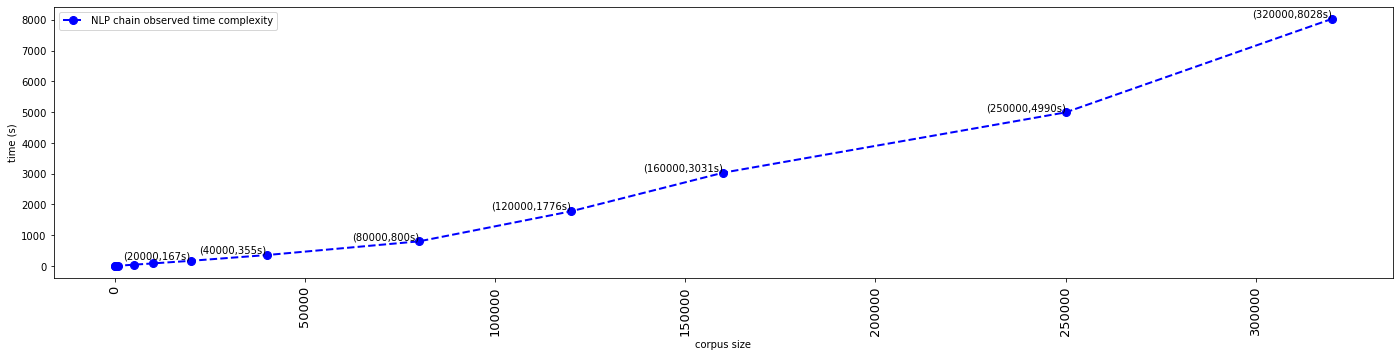

In [124]:
plt.figure(figsize=(24,5))
plt.xticks(fontsize=13, rotation=90) 
plt.plot(NLP_benchmark["size"],NLP_benchmark["time"],'bo', linewidth=2, linestyle='dashed', markersize=8,label="NLP chain observed time complexity")  

for i,row in NLP_benchmark.iterrows():
    if row['size']>10000:
        plt.annotate("("+str(int(row["size"]))+","+str(int(row["time"]))+"s)", (row["size"], row["time"]),va="bottom", ha="right") 

plt.legend()
plt.xlabel("corpus size")
plt.ylabel("time (s)")
plt.show()

In [125]:
display(NLP_benchmark)

,size,time
0,10.0,1.424516
1,100.0,1.560639
2,1000.0,8.958726
3,5000.0,41.626510
4,10000.0,82.867986
5,20000.0,167.945835
6,40000.0,355.106583
7,80000.0,800.006889
8,120000.0,1776.853320
9,160000.0,3031.236519


### Small size, small time

When running on small datasets, the pipeline will have a constant time dedicated to setting up its context, structuring variables, calling functions, transmitting parameters. 

We cannot neglect this constant time, otherwise we could work on a wrong basis when approximating the polynomial coefficients.

Let's do some more studies, this time on very small datasets.

In [126]:
NLP_small_benchmark_nobatch_file = dataset_path+"NLP_small_benchmark_nobatch.pkl"

In [127]:
sample_sizes=np.arange(1,50,1)
nb_tests = 10 # run nb_tests times the same experiment to get mean values

In [128]:
if not exists(NLP_small_benchmark_nobatch_file):
    NLP_small_benchmark= pd.DataFrame(columns=["size","time"])
    verbose_level=0
    for N in tqdm(sample_sizes):
        print("Benchmark for N=",N)
        test_time=0
        for nb_test in range(0,nb_tests):
            df_sample=documents.sample(N).copy()
            t0=time()
            X = df_sample["text"].tolist()  
            X_prep=text_pipeline.fit_transform(X)
            t=time()-t0
            test_time+=t
        t=test_time/nb_tests
        print("... Time =",t,"s =",t/3600,"h")
        NLP_small_benchmark = NLP_small_benchmark.append({"size":N , "time":t},ignore_index=True) 
    

In [129]:
if exists(NLP_small_benchmark_nobatch_file):
    NLP_small_benchmark = pd.read_pickle(NLP_small_benchmark_nobatch_file)
else :
    NLP_small_benchmark.to_pickle(NLP_small_benchmark_nobatch_file)

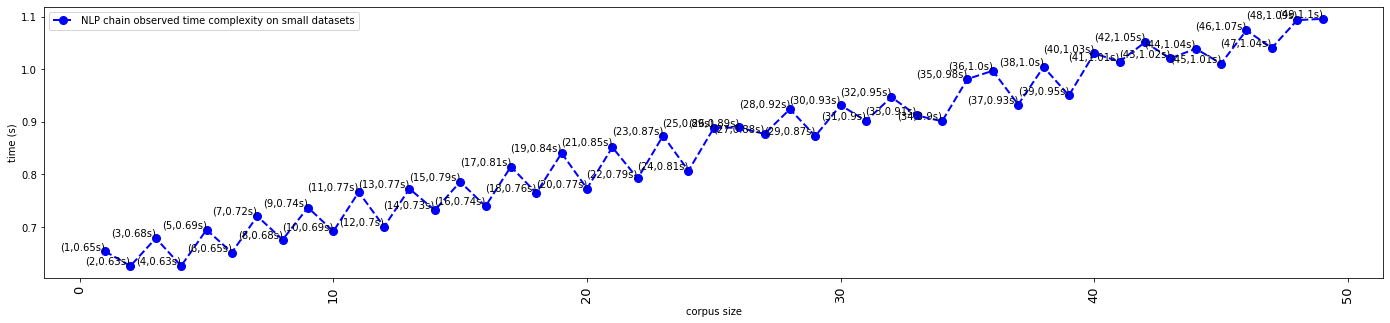

In [130]:
plt.figure(figsize=(24,5))
plt.xticks(fontsize=13, rotation=90) 
plt.plot(NLP_small_benchmark["size"],NLP_small_benchmark["time"],'bo', linewidth=2, linestyle='dashed', markersize=8,label="NLP chain observed time complexity on small datasets")  

for i,row in NLP_small_benchmark.iterrows():
    # if row['size']<1000:
    plt.annotate("("+str(int(row["size"]))+","+str(round(row["time"],2))+"s)", (row["size"], row["time"]),va="bottom", ha="right") 
plt.legend()
plt.xlabel("corpus size")
plt.ylabel("time (s)")
plt.show()


## Understand the pipeline complexity

Looking at the pipeline execution times on several corpus sizes, we can state that the pipeline complexity is not linear, but rather shows a quadratic tendency.


With the NLP libraries used in the pipeline, and the poor available documentation about their computational complexity, it is quite impossible to express precisely the pipeline processing time as a function of the corpus size. Moreover, the complexity depends on other factors such as sentences lengh and each parameter used to setup each pipeline step.

However with the observations we just made on various sampled subcorpora, we can approximate the pipeline complexity as a polynomial function of the corpus size. 

We will consider that this complexity is **at least quadratic** ( >= O(N²) ). Note that this is just a work hypothesis.

If the actual pipeline complexity appeared to be a polynomial of higher order (for instance O(N^3)), the optimizations computed with our method would still be efficient and would even allow a better computational economy.

If the actual pipeline tendency was not quadratic but a linear (with very big coefficient) or a composition of N and log(N) with high coefficients, our study would remain efficient as far as it is based on dividing N into smaller chunks.


### quadratic approximation of the pipeline

In [131]:
# group our benchmarks to have a full scope
max_small_sizes=NLP_small_benchmark['size'].max()


In [132]:
NLP_benchmark=pd.concat([NLP_small_benchmark,NLP_benchmark[NLP_benchmark['size']>max_small_sizes]],ignore_index=True)

Polynomial.fit coefficients for ax²+bx+c : (a,b,c)= 5.0847627911094145e-08 0.008491625768896248 -1.3111322693603142
Coefficients =  [-1.31113227e+00  8.49162577e-03  5.08476279e-08]
Residual =  [291878.67747369]


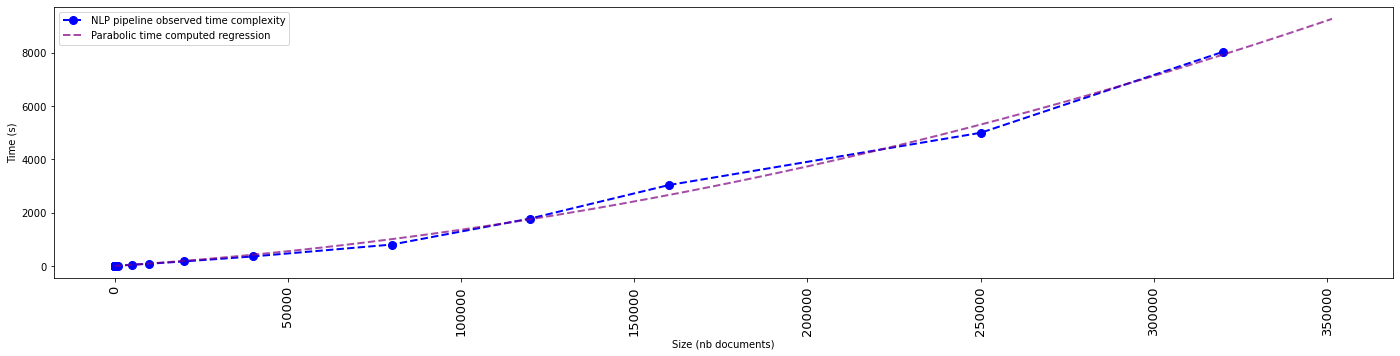

In [135]:
import numpy.polynomial.polynomial as nppol

plt.figure(figsize=(24,5))
plt.xticks(fontsize=13, rotation=90) 
plt.plot(NLP_benchmark["size"],NLP_benchmark["time"],'bo--', linewidth=2, markersize=8,label="NLP pipeline observed time complexity")  

max_x= len(documents)/8 # manual_NLP_benchmark["size"].max()

# ----------- approximation de la courbe de complexité en temps
df_approx=pd.DataFrame(columns=["x"])
line_x = np.arange(0,max_x+1,100)
df_approx["x"]=line_x
 
# ----------- (quadratic) polynomial regression with Numpy
pp , [resid, rank, sv, rcond] = nppol.Polynomial.fit(NLP_benchmark["size"],NLP_benchmark["time"], 2, full=True) # quadratic regression
# see https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html#numpy.polynomial.polynomial.Polynomial.fit
# pp will contain our coefficients
# resid is the residual value =  sum of the squares of the fit errors
# a high residual value can be due to statistical noise, or poor fitting

# ppc=pp.coef
ppcc=pp.convert().coef
# print("Polynomial.fit coefficients for ax²+bx+c : (a,b,c)=",ppc[2],ppc[1],ppc[0])
print("Polynomial.fit coefficients for ax²+bx+c : (a,b,c)=",ppcc[2],ppcc[1],ppcc[0])
print("Coefficients = ",ppcc)
print("Residual = ",resid)
# df_approx["reg_y"] = df_approx["x"].apply(lambda x: ppc[2]*(x**2) + ppc[1]*x + ppc[0])
# plt.plot(df_approx["x"], df_approx["reg_y"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Parabolic time computed regression")
df_approx["reg_cy"] = df_approx["x"].apply(lambda x: ppcc[2]*(x**2) + ppcc[1]*x + ppcc[0])
plt.plot(df_approx["x"], df_approx["reg_cy"], color='purple',alpha=.7, linewidth=2, linestyle='dashed', label="Parabolic time computed regression")  
 

plt.legend()
plt.xlabel("Size (nb documents)")
plt.ylabel("Time (s)")
plt.show()

### constant term correction in the polynomial approximation

Now let's have a closer look at the polynomial approximation for small corpus sizes.

We observe that the constant term 'c' is negative. This does not account for the values we found on small datasets. We have to correct this constant term, otherwise our optimization process will give us a bad optimal batch size.

In [138]:
print("The polynomial constant term is ",ppcc[0])
print("The minimal value of our obseved times is ",NLP_small_benchmark["time"].min())

The polynomial constant term is  -1.3111322693603142
The minimal value of our obseved times is  0.6255682706832886


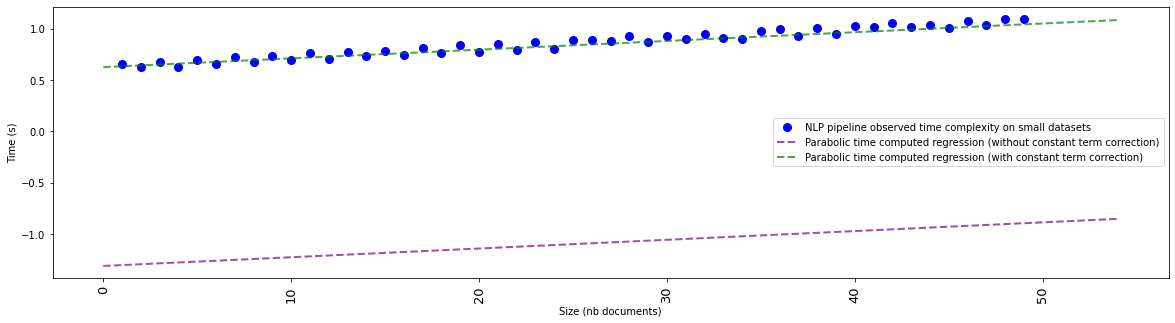

In [140]:
import numpy.polynomial.polynomial as nppol

plt.figure(figsize=(20,5))
plt.xticks(fontsize=13, rotation=90) 
plt.plot(NLP_small_benchmark["size"],NLP_small_benchmark["time"],'bo', linewidth=2, markersize=8,label="NLP pipeline observed time complexity on small datasets")  

max_x= int(NLP_small_benchmark["size"].max())+5 # manual_NLP_benchmark["size"].max()

# ----------- approximation de la courbe de complexité en temps
df_approx=pd.DataFrame(columns=["x"])
line_x = np.arange(0,max_x+1,1)
df_approx["x"]=line_x
  
df_approx["reg_cy"] = df_approx["x"].apply(lambda x: ppcc[2]*(x**2) + ppcc[1]*x + ppcc[0])
plt.plot(df_approx["x"], df_approx["reg_cy"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Parabolic time computed regression (without constant term correction)")  
corrected_term=NLP_small_benchmark["time"].min()
df_approx["reg_ccy"] = df_approx["x"].apply(lambda x: ppcc[2]*(x**2) + ppcc[1]*x + corrected_term)
plt.plot(df_approx["x"], df_approx["reg_ccy"],  color='green', alpha=.7, linewidth=2, linestyle='dashed', label="Parabolic time computed regression (with constant term correction)")  
 

plt.legend()
plt.xlabel("Size (nb documents)")
plt.ylabel("Time (s)")
plt.show()

So finally we correct the constant term of our polynomial approximation, for more accurate approximations in the following study.

In [142]:
# we do not want the curve to move under 0 so we force the coefficient c=0 if c<0
if (ppcc[0]<corrected_term):
    ppcc[0]=corrected_term

**General expression of our pipeline complexity**

With all the experiments done so far, we have computed a polynomial expression of the pipeline time, given our computer hardware.

    Time(Pipeline(N)) = a x N² + b x N + c
    
We can now estimate the computation time for any value of N.


### predict computation time for larger corpus

Now that we have polynomial coefficients, we can estimate the computation time for any corpus size.

In [143]:
N = len(documents)

NLP_benchmark_predictions= pd.DataFrame(columns=["size","time"])
prediction_sizes=[N//8,N//7,N//6,N//5,N//4,N//3,N//2,N]
for n in prediction_sizes:
    estim_time=ppcc[2]*(n**2) + ppcc[1]*n + ppcc[0]
    print("estimated time (",n," documents) =",estim_time,"s =",estim_time/3600,"h")
    NLP_benchmark_predictions = NLP_benchmark_predictions.append({"size":n , "time":estim_time},ignore_index=True)
 

estimated time ( 351471  documents) = 9266.48801664153 s = 2.5740244490670916 h
estimated time ( 401682  documents) = 11615.743678509165 s = 3.226595466252546 h
estimated time ( 468629  documents) = 15146.85486957549 s = 4.207459685993192 h
estimated time ( 562354  documents) = 20856.081915640836 s = 5.79335608767801 h
estimated time ( 702943  documents) = 31095.03493805774 s = 8.637509705016038 h
estimated time ( 937258  documents) = 52626.69858858576 s = 14.618527385718266 h
estimated time ( 1405887  documents) = 112440.15672530147 s = 31.233376868139295 h
estimated time ( 2811774  documents) = 425882.2176416814 s = 118.30061601157816 h


Polynomial.fit coefficients for ax²+bx+c : (a,b,c)= 5.0847627911094145e-08 0.008491625768896248 0.6255682706832886
Coefficients =  [6.25568271e-01 8.49162577e-03 5.08476279e-08]
Residual =  [291878.67747369]


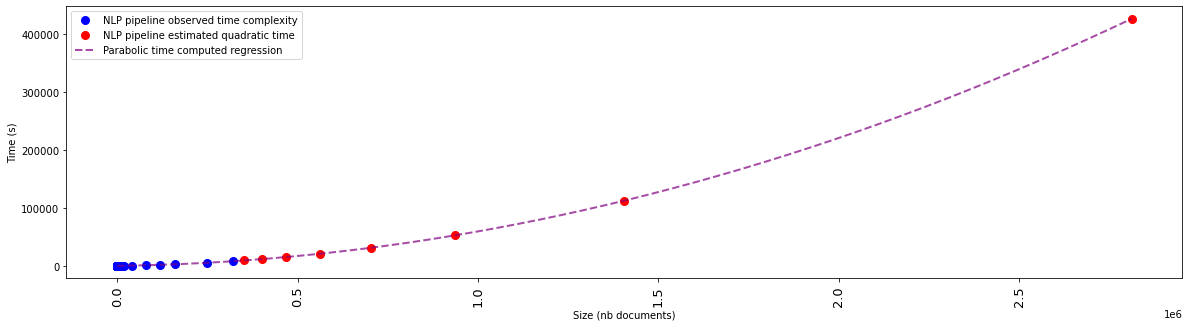

In [144]:
plt.figure(figsize=(20,5))
plt.xticks(fontsize=13, rotation=90) 

plt.plot(NLP_benchmark["size"],NLP_benchmark["time"],'bo', linewidth=2, markersize=8,label="NLP pipeline observed time complexity")  

plt.plot(NLP_benchmark_predictions["size"],NLP_benchmark_predictions["time"],'ro', linewidth=2, markersize=8,label="NLP pipeline estimated quadratic time")  

max_x= len(documents) # manual_NLP_benchmark["size"].max()

# ----------- approximation de la courbe de complexité en temps
df_approx=pd.DataFrame(columns=["x"])
line_x = np.arange(0,max_x+1,1000)
df_approx["x"]=line_x
 
# ----------- (quadratic) polynomial regression with Numpy
 
print("Polynomial.fit coefficients for ax²+bx+c : (a,b,c)=",ppcc[2],ppcc[1],ppcc[0])
print("Coefficients = ",ppcc)
print("Residual = ",resid) 
df_approx["reg_cy"] = df_approx["x"].apply(lambda x: ppcc[2]*(x**2) + ppcc[1]*x + ppcc[0])
plt.plot(df_approx["x"], df_approx["reg_cy"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Parabolic time computed regression")  
 

plt.legend()
plt.xlabel("Size (nb documents)")
plt.ylabel("Time (s)")
plt.show()

# Optimize time complexity by dividing the corpus into smaller chunks

This study is explained in the following blog article : https://tristanv.medium.com/accelerate-nlp-preprocessing-pipeline-by-optimizing-a-batch-processing-loop-cf18dc7ee036

We reproduce our method steps hereunder:

1. Evaluate the Split+Compute+Merge complexity of the batch-processing loop over a constant pipeline
2. Estimate the batch-processing complexity as a function of batch number
3. Find the minimum of the batch processing time for a given corpus size
4. Run the optimal batch processing loop and verify our estimation




## To batch or not to batch

We will now verify experimentally and computationally that **a division of NLP processing operations into several sub-corpuses of reasonable size will have a better complexity than processing the whole documents in 1 pass**.

This means that we expect to reduce _Time(Processing(N))_ by dividing *N* into *z* chunks of size *B=N/z*

Process N elements gives actually the same result as processing _z_ times _N/z_ elements.

Because _Time(Processing(N)) = O(N²)_, we have

     z x Time(Processing(N/z)) = z x O(N²/z²) = O(N²/z) 
     
Splitting into _z_ batches therefore allows us to reduce to a complexity that is still quadratic, but _z_ times smaller than on a single batch of size _N_.

However, the envisaged division generates an **additional cost** according to the number of batches. Indeed, the following *non-zero* actions must be measured:
- Splitting the corpus of size _N_ into _z_ chunks of size _B = N/z_, with _z > 1_, 
- Storing/assigning the pipeline output of each batch into a place in memory,
- Joining the _z_ batches outputs into a variable , to retrieve an equivalent result as with the one-pass operation.

Finally our Batch Processing loop will have the following complexity:

    Time(Batch_Processing(N)) = Time(Batch_SplitAssignJoin(N,z)) + (z x Time(Processing(N/z)))

We will now observe with a graphical studythat the splitting/assigning/joining operations are a linear function of the batch count.

    Time(Batch_SplitAssignJoin(N,z)) = O(z) = d x z + e , (with d,e positive constants depending on our hardware configuration)



## Evaluate the Split+Compute+Merge complexity of the batch-processing loop over a constant pipeline

In [145]:
# estimation du temps de découpage+assignation+réunion du dataframe "documents" de taille N en z lots de taille B = N/z

def compute_documents_batch_split_assign_join_complexity():
    documents = pd.read_pickle(documents_initial_working_file)
    documents["new_col"]="" # for our tests
    # #test avec un sous ensemble
    # # documents=documents.sample(400000).copy()
 
    sample_size = len(documents)
    
    def eval_batchtime(df,batch_size):
        # compute time for split+assign+merge on a batch processing over a dataframe df
        t0=time() 
        nb_batch=0
        new_col=[]
        for i in range(0,df.shape[0],batch_size):
            nb_batch=nb_batch+1
            t1=time()
            
            df_batch = df[i:i+batch_size] # split
            
            # our simple pipeline
            X = df_batch["text"].tolist()
            
            X_pred=X # a simple *innocent* assignment
            
            new_col.extend(X_pred) # consolidation
            
        # end batch loop
        
        df["new_col"]=new_col # final assignment
        batchtime=time()-t0
        return batchtime
 
    df_batchtime=pd.DataFrame(columns=["test","nb_batches","batch_size","time"])
    nb_batches=[1,2,3,4,5,6,7,8,9,10,15,20,25,50,75,100,150,200,250,500,1000,5000,10000,20000,40000,60000]
    nb_tests=3
    print(" --- "*10,"Computing batch times")
    for test in tqdm(range(0,nb_tests)):
        # for each test loop we shuffle the dataframe, so that we get various situations 
        # to shuffle the dataframe in-place and reset the index without creating new index columns, do drop=True: 
        documents = documents.sample(frac=1).reset_index(drop=True)
        # print(" --- "*5,"Test",test)
        for z in nb_batches:
            b=int(round(sample_size/z,0)) 
            t=eval_batchtime(documents,b)
            df_batchtime=df_batchtime.append({
                "test":test,
                "nb_batches":z,
                "batch_size":b,
                "time":t
            },ignore_index=True)
    print(" --- "*10,"Finished computing batch times") 
    return df_batchtime
# end function


# inverser les commentaires dans les 4 lignes ci dessous pour exécuter le calcul des stats, ou bien pour le charger depuis un fichier temporaire
if (not exists(dataset_path+"batchtime_splitmerge_eval.pkl")):
    df_batchtime = compute_documents_batch_split_assign_join_complexity()
    df_batchtime.to_pickle(dataset_path+"batchtime_splitmerge_eval.pkl")
else:
    df_batchtime = pd.read_pickle(dataset_path+"batchtime_splitmerge_eval.pkl")

In [146]:
df_mean=df_batchtime[['nb_batches','batch_size','time']].groupby('nb_batches').mean()
df_mean.reset_index(inplace=True)
df_mean

,nb_batches,batch_size,time
0,1.0,2811774.0,0.995954
1,2.0,1405887.0,1.033495
2,3.0,937258.0,1.056837
3,4.0,702944.0,1.095618
4,5.0,562355.0,1.070075
5,6.0,468629.0,1.096490
6,7.0,401682.0,1.099465
7,8.0,351472.0,1.101991
8,9.0,312419.0,1.108370
9,10.0,281177.0,1.108954


In [147]:

# ----------- linear regression with Numpy
lp , [resid, rank, sv, rcond] = nppol.Polynomial.fit(df_mean[df_mean['nb_batches']>=50]["nb_batches"],df_mean[df_mean['nb_batches']>=50]["time"], 1, full=True) # linear regression 
 
lpcc=lp.convert().coef 
print("Polynomial.fit coefficients for dx+e : (d,e)=",lpcc[1],lpcc[0])
print("Coefficients = ",lpcc)
print("Residual = ",resid)
df_mean["reg_cy"] = df_mean["nb_batches"].apply(lambda x: lpcc[1]*x + lpcc[0])
 

Polynomial.fit coefficients for dx+e : (d,e)= 0.0001452622186632931 1.1553408737355637
Coefficients =  [1.15534087e+00 1.45262219e-04]
Residual =  [0.02481811]


Let's look at the full curve : complexities appear to follow a linear tendency when batch count is great enough. 

For small values of batch count, we should look closer.

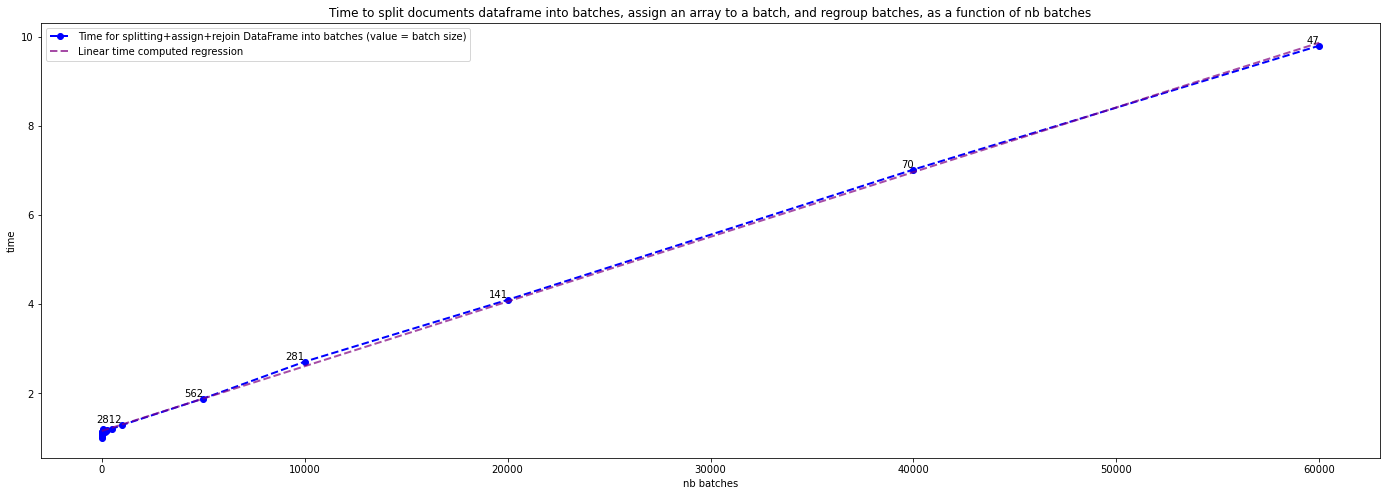

In [148]:
plt.figure(figsize=(24,8))
plt.title("Time to split documents dataframe into batches, assign an array to a batch, and regroup batches, as a function of nb batches")
plt.plot(df_mean["nb_batches"],df_mean["time"],'bo', linestyle='dashed', linewidth=2,label="Time for splitting+assign+rejoin DataFrame into batches (value = batch size)")
plt.plot(df_mean["nb_batches"],df_mean["reg_cy"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Linear time computed regression")  

for i,row in df_mean.iterrows():
    if row["nb_batches"]>500:
        plt.annotate(str(int(row["batch_size"])), (row["nb_batches"], row["time"]),va="bottom", ha="right") 
plt.legend()
plt.xlabel("nb batches")
plt.ylabel("time")
plt.show()

Let's look at the small area when batch count is <500 

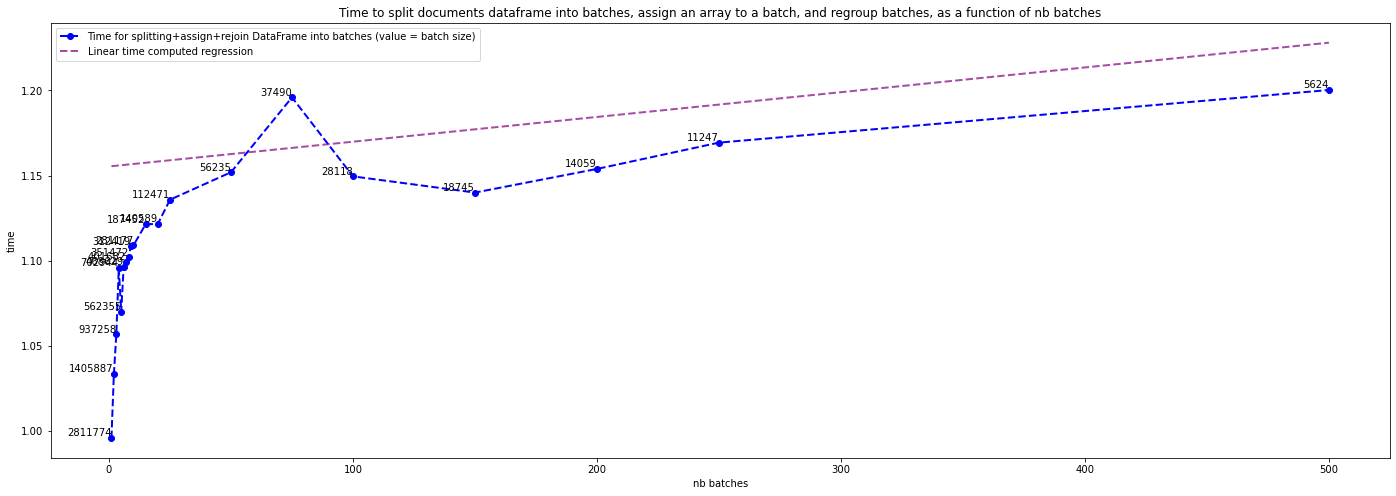

In [149]:
plt.figure(figsize=(24,8))
plt.title("Time to split documents dataframe into batches, assign an array to a batch, and regroup batches, as a function of nb batches")
df_window=df_mean[df_mean['nb_batches']<=500]
plt.plot(df_window["nb_batches"],df_window["time"],'bo', linestyle='dashed', linewidth=2,label="Time for splitting+assign+rejoin DataFrame into batches (value = batch size)")
plt.plot(df_window["nb_batches"],df_window["reg_cy"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Linear time computed regression")  

for i,row in df_window.iterrows():
    plt.annotate(str(int(row["batch_size"])), (row["nb_batches"], row["time"]),va="bottom", ha="right") 
plt.legend()
plt.xlabel("nb batches")
plt.ylabel("time")
plt.show()

At this point, we have looked at the extra costs (split/assign/join) implied by the batch processing loop. A few conclusions can be made:
- these cost grow as a linear function of the batch number _z_ when _z_ is big enough,
- for low values of _z_ the extra cost grows very fast, before reaching the linear slope
- all the costs considered when _z_ is low (the fast growth window) are remaining under the ceil of the linear function, and they may be neglected (less than 1.2s) in front of the processing cost itself (several hours when N>1M)

For these reasons, we may consider the extra costs as a linear function of the batch number _z_ for all values of _z_
    

## Evaluate the full batch processing loop complexity

 
Finally, summarizing what we computed so far, we can express the complexity of a batch processing loop over z chunks of size B=N/z :
    
    Time(Batch_Processing(N,z)) = Time(Batch_SplitAssignJoin(N,z)) + (z x Time(Processing(N/z)))
    = (d x z) + e + (z x Time(Processing(N/z))) 
    = d x z + e + (z x ( a x (N/z)² + b x (N/z) + c)) 
    = d x z + e + c x z + N x b + a x (N²/z) 
    = a x (N²/z) +  N x b + (c+d) x z + e

The complexity of the batch processing loop is a function of two variables : _N_ and _z_ .

    Time(Batch_Processing(N,z)) = a x (N²/z) +  N x b + (c+d) x z + e

As a polynomial function of _N_, we should observe a parabolic curve growing with a _a/z_ slope.

For a given value _N_, the function evolves as an inverse function of _z_ added to a linear function of _z_.

Let's look at a few variations of the complexity curve with various values of _z_

In [154]:
# size of the corpus 
N = len(documents)

# coefficients of the pipeline quadratic complexity
# Time(Pipeline(N)) = a * N² + b * N + c
a = ppcc[2]
b = ppcc[1]
c = ppcc[0]
print("Time(Processing(N)) = ",a," * N² + ",b," * N +", c)

# coefficients of the batch loop split+assign+join linear complexity
# Time(Batch_SplitAssignJoin(N,z)) = d * z² + e
d = lpcc[1]
e = lpcc[0]
print("Time(Batch_SplitAssignJoin(N,z)) = ",d," * z² + ",e)

Time(Processing(N)) =  5.0847627911094145e-08  * N² +  0.008491625768896248  * N + 0.6255682706832886
Time(Batch_SplitAssignJoin(N,z)) =  0.0001452622186632931  * z² +  1.1553408737355637


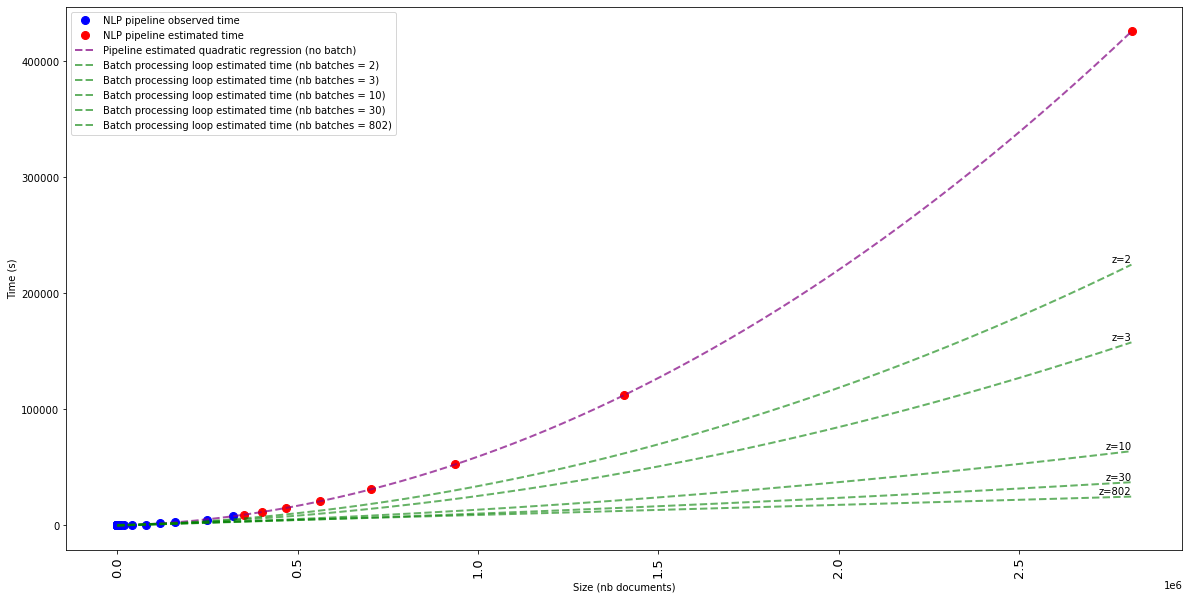

In [159]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize=13, rotation=90) 

plt.plot(NLP_benchmark["size"],NLP_benchmark["time"],'bo', linewidth=2, markersize=8,label="NLP pipeline observed time")  

plt.plot(NLP_benchmark_predictions["size"],NLP_benchmark_predictions["time"],'ro', linewidth=2, markersize=8,label="NLP pipeline estimated time")  

max_x= N  

# ----------- let's draw several curves with same x values
df_approx=pd.DataFrame(columns=["x"])
line_x = np.arange(0,max_x+1,1000)
df_approx["x"]=line_x
 
# ----------- pipeline quadratic regression
 
df_approx["reg_cy"] = df_approx["x"].apply(lambda x: a*(x**2) + b*x + c)
plt.plot(df_approx["x"], df_approx["reg_cy"],  color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Pipeline estimated quadratic regression (no batch)")  


# ----------- several batches

z_optimal = int(round(math.sqrt( (a*N*N) / (c+d)),0)) # see how we come to this value further in the notebook
nb_batches=[2,3,10,30,z_optimal]

for z in nb_batches:
    df_approx["batch_y"] = df_approx["x"].apply(lambda x: a*x*x/z +  x*b + (c+d)*z + e)
    plt.plot(df_approx["x"], df_approx["batch_y"],  color='green', alpha=.6, linewidth=2, linestyle='dashed', label="Batch processing loop estimated time (nb batches = "+str(z)+")")  
    last_row = df_approx.iloc[-1]
    plt.annotate("z="+str(z), (last_row["x"], last_row["batch_y"]),va="bottom", ha="right") 

plt.legend()
plt.xlabel("Size (nb documents)")
plt.ylabel("Time (s)")
plt.show()

With a big enough value of *z* (N²/z small enough), we can reduce significantly the processing time.

Over this value of _z_, the processing time will start growing again instead of decreasing, because of the extra costs.

Let's find out now how to calculate the minimal processing time that we can expect with a given value of N and an optimal value of _z_.


## Calculate the optimal batch count minimizing the batch processing time

Let's find a value of *z* such that Time(Batch_Processing(N,z)) is minimal: **the minimum is reached when the derivative of function Time(Batch_Processing(N,z)) with respect to *z* equals 0**:

We have :

    Time(Batch_Processing(N,z)) = a x (N²/z) +  N x b + (c+d) x z + e
    
So the derivative is :

    deriv( Time(Batch_Processing(N,z)) , z) = -a x N² / z² + (c+d)

So we have 

    deriv( Time(Batch_Processing(N,z)) , z) = 0 
    <=> -a x N² / z² + (c+d) = 0
    <=> 1 / z² = (c+d) / (a x N²)
    <=> z² = (a x N²) / (c+d)
    <=> z = square_root( (a x N²) / (c+d))

The graphical study here under should show how the full processing time evolves as a function of *z* when *N* is fixed (and big) and confirm this optimal value.

In [160]:

z_optimal = int(round(math.sqrt( (a*N*N) / (c+d)),0))
print("We estimate the optimal batch count : z_optimal = sqrt(",a*N*N," / ",(c+d),") =",z_optimal)
optimal_batch_size=N//z_optimal
print("The optimal batch size is : N / z_optimal = ",N," / ",z_optimal," =",optimal_batch_size)
optimal_time = int(a*N*N/z_optimal +  b*N + (c+d)*z_optimal + e)
print("The optimal time is then : a x (N²/z) +  N x b + (c+d) x z + e = ",optimal_time," s = ",(optimal_time/3600),"h")

We estimate the optimal batch count : z_optimal = sqrt( 402005.0595186982  /  0.6257135329019519 ) = 802
The optimal batch size is : N / z_optimal =  2811774  /  802  = 3505
The optimal time is then : a x (N²/z) +  N x b + (c+d) x z + e =  24880  s =  6.911111111111111 h


'Minimal computation time can be expected for z=802'

,z,batch_processing_time,batch_size
797,798.0,24880.773034,3523.0
798,799.0,24880.768252,3519.0
799,800.0,24880.765046,3514.0
800,801.0,24880.763411,3510.0
801,802.0,24880.763340,3505.0
802,803.0,24880.764828,3501.0
803,804.0,24880.767869,3497.0
804,805.0,24880.772457,3492.0
805,806.0,24880.778586,3488.0


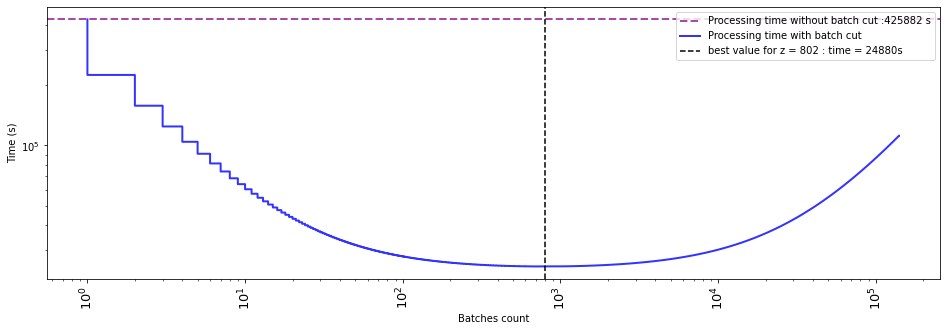

In [151]:
plt.figure(figsize=(16,5))
plt.xticks(fontsize=13, rotation=90) 

N= len(documents) 
max_z = N/20 # we 'hope' not to get under chunks of 20 elements

# ----------- approximation de la courbe de complexité en temps
df_approx=pd.DataFrame(columns=["z"])
line_z = np.arange(1,max_z+1,1)
df_approx["z"]=line_z
 
df_approx["batch_processing_time"] = df_approx["z"].apply(lambda z: a*N*N/z +  N*b + (c+d)*z + e)
df_approx["batch_size"]= N//df_approx["z"]
display("Minimal computation time can be expected for z="+str(z_optimal)+"",df_approx[(df_approx["z"]>(z_optimal-5)) & (df_approx["z"]<(z_optimal+5))])

plt.axhline(y=(a*N*N +  b*N + c), color='purple', alpha=.7, linewidth=2, linestyle='dashed', label="Processing time without batch cut :"+str(int(a*N*N +  b*N + c))+" s") 
plt.step(df_approx["z"], df_approx["batch_processing_time"], color='blue', alpha=.8, linewidth=2, linestyle='solid', label="Processing time with batch cut") 

plt.axvline(x=z_optimal, color='k', linestyle='--', label="best value for z = "+str(z_optimal)+" : time = "+str(optimal_time)+"s")  
 
plt.legend()
plt.xlabel("Batches count")
plt.xscale("log")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

The above study shows that we can drastically accelerate the process thanks to the calculated batch count.


## Confirm the estimations with an actual batch processing loop over the full corpus.

In [152]:
# reopen the documents dataset prepared earlier for a fresh start
# documents_initial_working_file = dataset_path+"documents_txt.pkl"
documents = pd.read_pickle(documents_initial_working_file)

In [153]:
documents_NLP_working_file = dataset_path+'clean_documents.pkl'

## Batch processing technique
nb_batches = z_optimal # see our previous calculation of optimal batch size
batch_size = int(round(len(documents)/nb_batches))

nb_batch=0
verbose_level=0

log_file = dataset_path+'batch_log.txt'
if exists(log_file):
    remove(log_file)

logger = open(log_file,"w")

t0=time()
text_prepared=[]
print(" --- "*5,"Starting batch process : nb_batches =",z_optimal," batch size=",batch_size," documents size=",len(documents))
logger.write('Starting batch process\n')
for i in range(0,documents.shape[0],batch_size):
    nb_batch=nb_batch+1
    t1=time()
    df_batch = documents[i:i+batch_size] # split
    X = df_batch["text"].tolist() 
    X_prep = text_pipeline.fit_transform(X) # assign
    text_prepared.extend(X_prep) # join
    logger.write("... batch i = "+str(nb_batch)+" len(df_batch)="+str(len(df_batch))+" len(X_prep)="+str(len(X_prep))+" time = "+str(time()-t1)+" s\n")
    
documents["text_POS_prepared"] = text_prepared # final join

t2=time()

print(" --- "*5)
print(" --- "*5, "End of batch process : nb batches = ",nb_batch)
print("Batch loop done in %0.3fs." % (t2 - t0))
logger.write("End of batch process : nb_batches = "+str(nb_batch)+" time = "+str(t2-t0)+" s\n")

documents['terms']=get_unsentenced_unPOStagged_list(documents['text_POS_prepared'])
documents['clean_text']=documents['terms'].apply(lambda x : ' '.join(x))

display(documents)

logger.close()

documents.to_pickle(documents_NLP_working_file)

 ---  ---  ---  ---  ---  Starting batch process : nb_batches = 802  batch size= 3506  documents size= 2811774
 ---  ---  ---  ---  --- 
 ---  ---  ---  ---  ---  End of batch process : nb batches =  802
Batch loop done in 25059.145s.


,tweet_id,text,text_POS_prepared,terms,clean_text
0,1,@115712 I understand. I would like to assist y...,"[[( , SPACE), (user, PROPN), (i, PRON), (under...","[ , user, i, understand, i, would, like, to, a...",user i understand i would like to assist you...
1,2,@sprintcare and how do you propose we do that,"[[( , SPACE), (user, PROPN), (and, CCONJ), (ho...","[ , user, and, how, do, you, propose, we, do, ...",user and how do you propose we do that
2,3,@sprintcare I have sent several private messag...,"[[( , SPACE), (user, PROPN), (i, PRON), (have,...","[ , user, i, have, send, several, private, mes...",user i have send several private message and...
3,4,@115712 Please send us a Private Message so th...,"[[( , SPACE), (user, X), (please, INTJ), (send...","[ , user, please, send, we, a, private, messag...",user please send we a private message so tha...
4,5,@sprintcare I did.,"[[( , SPACE), (user, PROPN), (i, PRON), (do, A...","[ , user, i, do]",user i do
...,...,...,...,...,...
2811769,2987947,"@823869 Hey, we'd be happy to look into this f...","[[( , SPACE), (user, X), (hey, PROPN), (we, PR...","[ , user, hey, we, would, be, happy, to, look,...",user hey we would be happy to look into this...
2811770,2987948,@115714 wtf!? I’ve been having really shitty s...,"[[( , SPACE), (user, PROPN), (wtf, PROPN)], [(...","[ , user, wtf, i, ve, be, have, really, shitty...",user wtf i ve be have really shitty service ...
2811771,2812240,@143549 @sprintcare You have to go to https://...,"[[( , SPACE), (user, PROPN), (user, PROPN), (y...","[ , user, user, you, have, to, go, to, link, a...",user user you have to go to link and ask the...
2811772,2987949,"@823870 Sounds delicious, Sarah! 😋 https://t.c...","[[( , SPACE), (user, PROPN), (sound, VERB), (d...","[ , user, sound, delicious, sarah, link]",user sound delicious sarah link


## in Batch we trust

We can now achieve our work with some conclusions!

In [167]:
print("The text corpus is composed of",N,"documents.")
pipeline_time_seconds=round(a*N*N+b*N+c,0)
pipeline_time_hours=round(pipeline_time_seconds/3600,2)
print("Without batch processing, our pipeline would have been running ",pipeline_time_seconds,"s or ",pipeline_time_hours,"h.")
print("With our method, we estimated the optimal batch number =",z_optimal,"batches. Each batch containing",optimal_batch_size,"elements.")
optimal_time_seconds=round(optimal_time,0)
optimal_time_hours=round(optimal_time_seconds/3600,2)
print("Still with this method, we estimated the time needed to batch-process the pipeline =",optimal_time_seconds,"s or",optimal_time_hours,"hours.")
actual_time_seconds=round(t2-t0,0)
actual_time_hours=round(actual_time_seconds/3600,2)
print("The batch process over our corpus with the optimal batch count was finally executed in",actual_time_seconds,"s or",actual_time_hours,"hours.")
error_against_optimal_estimation = round(100*abs(actual_time_seconds-optimal_time_seconds)/optimal_time_seconds,2)
error_against_nobatch_estimation = round(100*abs(actual_time_seconds-optimal_time_seconds)/pipeline_time_seconds,2)
print("The difference between batch processing optimal time estimation and actual time is ",abs(actual_time_seconds-optimal_time_seconds),"s.")
print("This difference represents ",error_against_optimal_estimation,"% of the batch processing estimated time.")
print("This difference also represents ",error_against_nobatch_estimation,"% of the pipeline processing time.")
ratio=round(pipeline_time_seconds/actual_time_seconds,2)
print("Finally, our method divided the processing time by",ratio,".")


The text corpus is composed of 2811774 documents.
Without batch processing, our pipeline would have been running  425882.0 s or  118.3 h.
With our method, we estimated the optimal batch number = 802 batches. Each batch containing 3505 elements.
Still with this method, we estimated the time needed to batch-process the pipeline = 24880 s or 6.91 hours.
The batch process over our corpus with the optimal batch count was finally executed in 25059.0 s or 6.96 hours.
The difference between batch processing optimal time estimation and actual time is  179.0 s.
This difference represents  0.72 % of the batch processing estimated time.
This difference also represents  0.04 % of the pipeline processing time.
Finally, our method divided the processing time by 17.0 .


# End of notebook

---